In [2]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import numpy as np
from tqdm import tqdm
import os
from subprocess import Popen, PIPE
from scipy.stats import circmean, circstd

In [21]:
dots_bin = '../../examples/97_detect_dots/97_detect_dots'

In [11]:
def circmedian(angs, high = 2 * np.pi):
    """ Calculate circular median """
    angs = np.array(angs) / high * (2 * np.pi)
    pdists = angs[np.newaxis, :] - angs[:, np.newaxis]
    pdists = (pdists + np.pi) % (2 * np.pi) - np.pi
    pdists = np.abs(pdists).sum(1)
    return angs[np.argmin(pdists)]

In [30]:
def angle_dist(a1, a2, high = 360):
    a1 *= 360 / high
    a2 *= 360 / high
    v1 = np.abs(a1 - a2)
    v2 = 360 - v1
    return np.min([v1, v2], axis = 0) * high / 360

In [63]:
def get_mask(hsv, hmean = 0, hdelta = 10, smin = 100, smax = 255, vmin = 50, vmax = 255):

    # obtaining hsv channels
    h = hsv[:,:,0]
    s = hsv[:,:,1]
    v = hsv[:,:,2]
    
    # doing thresholding
    h_mask = angle_dist(h, hmean, high = 180) < hdelta
    s_mask = (s >= smin) & (s <= smax)
    v_mask = (v >= vmin) & (v <= vmax)
    mask = h_mask & s_mask & v_mask
    return mask

In [87]:
def get_dots_on_image(mask):
    """ Detect and return dots on the mask """
    
    # output temporary filename
    out_fn = '/tmp/tmpimgcvdots.png'
    
    # writing binarized image
    cv2.imwrite(out_fn, 1. * mask)
    
    def get_dots(in_fn):
        """ Run the 97_detect_dots project and output the detected dots """

        global bin_proc

        # run the executable (if not running)
        if not bin_proc:
            bin_proc = Popen([dots_bin], stdin=PIPE, stdout=PIPE)

        # writing data to the process
        bin_proc.stdin.write(in_fn + '\n')

        # obtaining the number of lines...
        n = int(bin_proc.stdout.readline().splitlines()[0])
        res = []
        for i in range(n):
            line = bin_proc.stdout.readline()
            line = line.splitlines()[0]
            line = [float(x) for x in line.split()]
            res += [line]

        # return the array with dots
        return res
    return get_dots(out_fn)

In [83]:
def get_stats(img, **kwargs):
    # obtaining HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # obtaining mask via thresholding
    mask = get_mask(hsv, **kwargs)
    
    # obtaining the list of points
    data = get_dots_on_image(mask)
    
    # obtaining HSV data for detected points
    hsv_points = []
    for point in data:
        point = [int(t) for t in point]
        point = hsv[point[1], point[0], :]
        hsv_points += [point]
    hsv_points = 1. * np.array(hsv_points)
    
    if len(hsv_points) == 0:
        return None, None
    
    stats = [None] * 3
    stats[0] = (circmean(hsv_points[:, 0], high = 180), circstd(hsv_points[:, 0], high = 180), circmedian(hsv_points[:, 0], high = 180))
    stats[1] = (np.mean(hsv_points[:, 1]), np.std(hsv_points[:, 1]), np.median(hsv_points[:, 1]))
    stats[2] = (np.mean(hsv_points[:, 2]), np.std(hsv_points[:, 2]), np.median(hsv_points[:, 2]))
    
    return data, stats

In [77]:
data, stats = get_stats(frame, hmean = 0, hdelta = 50, vmin = 50, smin = 50)

In [78]:
cv2.

[[238.721, 117.41],
 [213.039, 118.157],
 [309.143, 123.786],
 [264.106, 127.364],
 [320.864, 127.394],
 [281.424, 138.697],
 [331.333, 139.587],
 [300.556, 146.952],
 [201.352, 152.563],
 [218.375, 157.297],
 [259.072, 167.696],
 [325.897, 167.647],
 [309.138, 171.092],
 [243.077, 179.031],
 [207.429, 180.414],
 [315.985, 189.288],
 [206.833, 197.7],
 [300.716, 195.627],
 [244.463, 202.593],
 [317.621, 206.741],
 [296.717, 219.755],
 [241.171, 222.829],
 [337.615, 236.754],
 [240.571, 238.543],
 [324.661, 243.177],
 [228.038, 248.887]]

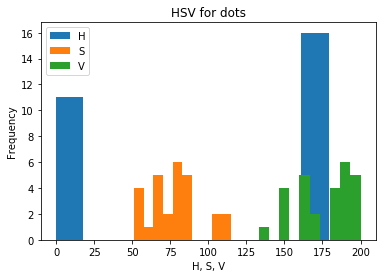

In [201]:
plt.figure()
plt.title('HSV for dots')
plt.xlabel('H, S, V')
plt.ylabel('Frequency')
plt.hist(hsv_points[:, 0], label = 'H')
plt.hist(hsv_points[:, 1], label = 'S')
plt.hist(hsv_points[:, 2], label = 'V')
plt.legend()

In [209]:
sigma = 2
mask = get_mask(img, hmean = stats[0][0], hdelta = sigma * stats[0][1],
             smin = stats[1][0] - sigma * stats[1][1], smax = stats[1][0] + sigma * stats[1][1],
             vmin = stats[2][0] - sigma * stats[2][1], vmax = stats[2][0] + sigma * stats[2][1])

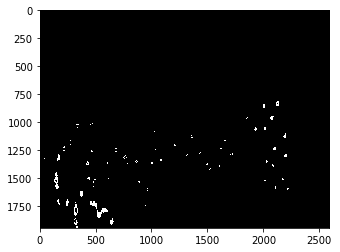

In [210]:
# plotting the image
plt.imshow(1. * mask, cmap = 'gray')
plt.show()

In [94]:
cap = cv2.VideoCapture('video_2018-11-25_17-32-23.mp4')
bin_proc = None
while(cap.isOpened()):
    ret, frame = cap.read()

    if not ret: break
    
    # threshold
    data, stats = get_stats(frame, hmean = 0, hdelta = 50, vmin = 50, smin = 50)
    
    # drawing circles
    if data:
        for point in data:
            cv2.circle(frame, tuple([int(t) for t in point]), 10, (1, 0, 0))
    
    cv2.imshow('frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[238.721, 117.41]
[213.039, 118.157]
[309.143, 123.786]
[264.106, 127.364]
[320.864, 127.394]
[335.5, 131.75]
[281.424, 138.697]
[331.333, 139.587]
[300.556, 146.952]
[201.352, 152.563]
[259.072, 167.696]
[325.897, 167.647]
[309.138, 171.092]
[243.077, 179.031]
[207.429, 180.414]
[315.985, 189.288]
[206.833, 197.7]
[300.716, 195.627]
[244.463, 202.593]
[317.621, 206.741]
[296.717, 219.755]
[241.171, 222.829]
[337.615, 236.754]
[240.571, 238.543]
[215.672, 241.134]
[324.661, 243.177]
[228.038, 248.887]
[213.92, 120.64]
[308.677, 125.29]
[264.171, 128.357]
[320.689, 128.041]
[338.5, 130.188]
[281.734, 139.578]
[330.883, 140.584]
[229.358, 140.313]
[312.429, 143.029]
[300.185, 148.692]
[200.074, 152.852]
[217.935, 158.081]
[259.882, 171.294]
[309.03, 171.773]
[243.0, 178.831]
[207.145, 180.355]
[267.5, 186.595]
[300.819, 196.403]
[207.057, 198.568]
[218.394, 197.788]
[244.017, 203.233]
[317.379, 207.758]
[219.022, 214.609]
[294.966, 220.207]
[241.0, 223.432]
[240.612, 239.269]
[338.068, 2

[285.689, 279.778]
[359.588, 282.647]
[318.114, 286.227]
[291.676, 293.471]
[406.6, 296.057]
[319.319, 308.511]
[388.9, 310.525]
[301.605, 316.093]
[333.537, 327.049]
[283.422, 330.556]
[405.306, 336.167]
[257.036, 337.786]
[353.789, 339.684]
[371.455, 339.636]
[316.17, 343.298]
[269.875, 344.958]
[382.154, 347.821]
[253.03, 351.303]
[386.265, 362.118]
[269.793, 368.724]
[332.75, 370.0]
[296.632, 371.368]
[354.81, 371.81]
[285.222, 278.933]
[358.824, 282.059]
[317.375, 286.104]
[291.488, 293.651]
[406.417, 295.667]
[319.021, 308.064]
[388.341, 309.932]
[301.2, 315.889]
[333.282, 327.128]
[283.154, 330.205]
[405.1, 336.075]
[256.867, 338.3]
[371.378, 339.267]
[353.051, 339.846]
[315.68, 342.68]
[269.654, 345.038]
[251.714, 351.357]
[385.417, 361.611]
[269.541, 367.649]
[331.75, 369.45]
[296.488, 371.122]
[353.703, 371.973]
[284.575, 278.275]
[358.59, 281.615]
[291.474, 294.079]
[405.786, 294.786]
[318.7, 307.54]
[387.9, 309.35]
[300.541, 315.838]
[332.351, 326.243]
[282.791, 329.721]
[4

[213.677, 201.415]
[320.493, 204.053]
[225.542, 208.576]
[287.06, 210.759]
[233.108, 71.1538]
[207.625, 72.3194]
[304.1, 79.0857]
[258.462, 81.1625]
[316.653, 81.84]
[292.158, 86.0789]
[223.342, 93.3421]
[275.324, 92.7353]
[307.118, 95.0395]
[295.549, 102.437]
[195.877, 106.178]
[226.432, 106.938]
[212.618, 111.073]
[242.0, 118.8]
[253.5, 122.875]
[285.523, 121.692]
[320.493, 123.014]
[304.156, 125.563]
[218.5, 123.5]
[236.703, 132.176]
[202.198, 134.63]
[262.702, 139.179]
[311.196, 144.089]
[202.111, 150.767]
[295.875, 150.35]
[214.976, 154.061]
[238.667, 156.386]
[312.292, 161.708]
[215.083, 170.222]
[289.726, 173.161]
[235.868, 176.618]
[235.839, 191.345]
[332.107, 190.413]
[211.103, 194.276]
[318.959, 196.541]
[223.377, 202.182]
[231.587, 63.9067]
[205.526, 64.0641]
[303.492, 71.4308]
[257.239, 72.7042]
[315.888, 74.5875]
[291.662, 78.7273]
[274.737, 85.0132]
[221.75, 85.875]
[306.408, 87.1447]
[294.39, 94.3781]
[194.423, 98.1408]
[224.575, 99.2466]
[212.129, 104.057]
[240.738, 110

[184.3, 144.1]
[279.606, 150.268]
[235.645, 152.79]
[291.717, 154.1]
[308.041, 156.122]
[268.453, 157.83]
[252.167, 163.803]
[282.86, 166.684]
[301.443, 165.557]
[271.0, 172.4]
[171.605, 176.526]
[202.643, 178.339]
[189.5, 181.532]
[217.581, 187.79]
[261.018, 191.456]
[195.954, 193.077]
[230.25, 192.714]
[295.754, 192.885]
[279.356, 195.237]
[213.392, 202.118]
[177.919, 204.242]
[238.139, 208.236]
[286.569, 213.207]
[270.969, 219.234]
[177.393, 220.377]
[190.574, 223.0]
[214.185, 225.944]
[287.536, 230.214]
[189.672, 237.828]
[264.968, 242.286]
[211.293, 245.638]
[306.984, 259.032]
[250.662, 260.887]
[209.667, 261.015]
[184.857, 263.302]
[293.209, 265.597]
[197.051, 270.932]
[259.56, 271.587]
[210.204, 134.833]
[279.841, 142.571]
[235.645, 144.21]
[291.635, 146.519]
[268.667, 149.456]
[308.776, 148.449]
[252.113, 155.742]
[301.542, 157.661]
[283.061, 158.408]
[271.242, 164.439]
[189.431, 173.231]
[202.5, 170.192]
[218.09, 179.507]
[230.5, 184.63]
[261.164, 183.418]
[195.778, 185.143]
[

[181.864, 99.7864]
[208.0, 99.4824]
[279.845, 107.775]
[234.268, 109.878]
[292.167, 111.131]
[309.333, 112.988]
[267.792, 114.701]
[251.244, 121.573]
[200.575, 121.025]
[301.889, 123.764]
[282.178, 124.575]
[270.829, 131.026]
[170.603, 134.205]
[200.184, 136.105]
[216.637, 146.837]
[260.065, 150.442]
[296.089, 151.684]
[194.161, 152.31]
[229.37, 151.315]
[279.821, 154.536]
[212.276, 160.684]
[175.158, 162.645]
[237.713, 167.494]
[286.854, 173.28]
[270.988, 179.434]
[175.306, 179.898]
[188.575, 182.391]
[213.695, 185.951]
[287.92, 190.92]
[188.321, 198.397]
[264.947, 202.933]
[210.684, 205.532]
[307.725, 220.212]
[209.925, 222.45]
[184.378, 224.568]
[294.28, 226.939]
[196.854, 232.598]
[183.396, 100.365]
[209.925, 100.225]
[281.256, 108.308]
[235.646, 110.463]
[293.75, 111.882]
[310.763, 113.688]
[269.159, 115.571]
[199.871, 121.829]
[252.923, 122.256]
[283.635, 125.111]
[303.875, 124.375]
[272.139, 131.75]
[172.289, 135.316]
[202.653, 136.987]
[218.771, 147.957]
[230.779, 151.412]
[262

[180.382, 104.146]
[206.581, 104.0]
[278.488, 112.354]
[232.325, 114.117]
[307.937, 117.873]
[266.0, 119.246]
[195.87, 126.043]
[249.464, 126.298]
[281.015, 128.652]
[300.378, 127.878]
[268.527, 135.351]
[198.933, 140.367]
[184.333, 145.022]
[214.2, 151.477]
[258.651, 155.145]
[226.973, 155.787]
[192.103, 157.287]
[294.361, 156.554]
[278.0, 159.444]
[209.694, 165.541]
[173.513, 166.923]
[234.975, 172.342]
[284.797, 178.278]
[171.828, 184.094]
[268.827, 184.074]
[209.984, 190.403]
[185.907, 203.653]
[207.778, 210.375]
[305.377, 224.974]
[206.243, 226.571]
[248.0, 226.868]
[291.921, 231.25]
[194.097, 236.806]
[177.163, 103.38]
[203.345, 103.369]
[275.625, 111.625]
[228.847, 113.389]
[287.831, 115.651]
[304.642, 117.519]
[263.074, 118.84]
[192.102, 124.78]
[246.321, 125.667]
[297.568, 127.877]
[278.485, 128.368]
[265.795, 135.038]
[163.914, 138.114]
[195.357, 139.726]
[181.439, 143.053]
[211.192, 150.658]
[223.56, 155.2]
[255.384, 154.836]
[188.442, 156.488]
[291.268, 156.056]
[274.549, 1

[190.353, 106.618]
[216.25, 106.75]
[241.217, 117.478]
[314.282, 121.821]
[274.4, 122.9]
[205.565, 128.674]
[258.367, 128.933]
[288.113, 132.264]
[307.958, 131.125]
[276.622, 138.622]
[178.538, 140.0]
[201.722, 157.778]
[267.231, 157.769]
[302.696, 159.217]
[285.872, 162.436]
[219.457, 167.348]
[184.371, 168.257]
[244.586, 173.931]
[292.974, 179.632]
[276.972, 186.472]
[220.444, 190.389]
[294.206, 196.735]
[197.405, 203.108]
[271.308, 208.346]
[218.5, 210.5]
[192.614, 228.035]
[217.256, 226.872]
[258.265, 226.941]
[314.333, 226.3]
[299.966, 231.932]
[266.461, 237.145]
[204.757, 236.541]
[202.302, 106.075]
[228.133, 105.833]
[252.324, 116.029]
[324.386, 120.068]
[285.257, 121.229]
[217.585, 127.122]
[269.107, 127.393]
[299.305, 130.458]
[318.5, 129.952]
[287.957, 136.587]
[190.2, 138.6]
[277.556, 156.056]
[212.717, 157.37]
[313.1, 158.2]
[296.86, 160.6]
[230.957, 165.915]
[195.75, 166.667]
[254.657, 172.514]
[303.147, 178.676]
[287.839, 185.065]
[231.78, 189.049]
[304.5, 195.5]
[207.811

[179.324, 108.265]
[205.634, 107.789]
[276.871, 115.514]
[231.584, 117.922]
[288.947, 119.263]
[306.32, 121.56]
[264.716, 123.338]
[195.644, 129.945]
[248.544, 129.987]
[299.591, 131.364]
[280.847, 132.356]
[268.288, 138.637]
[167.466, 142.409]
[198.356, 143.851]
[184.854, 147.549]
[213.884, 154.913]
[226.304, 159.013]
[258.232, 158.203]
[293.682, 159.409]
[191.378, 160.683]
[277.026, 162.649]
[209.163, 169.0]
[172.833, 170.59]
[235.055, 175.288]
[284.078, 181.234]
[172.671, 187.342]
[268.595, 187.135]
[186.459, 189.581]
[211.067, 192.88]
[285.338, 198.597]
[185.691, 206.79]
[262.391, 211.266]
[207.948, 213.351]
[306.056, 227.5]
[207.455, 229.753]
[248.173, 229.778]
[181.954, 231.431]
[291.819, 234.528]
[194.679, 239.185]
[258.108, 240.608]
[179.662, 105.352]
[206.451, 104.866]
[278.145, 112.675]
[232.488, 114.75]
[289.636, 116.818]
[307.653, 118.792]
[266.167, 120.59]
[196.212, 127.047]
[249.415, 127.11]
[300.536, 128.774]
[281.271, 129.871]
[268.802, 136.302]
[167.538, 139.925]
[198.

[165.86, 95.9741]
[192.893, 93.7143]
[266.228, 105.554]
[218.81, 104.381]
[182.316, 116.255]
[236.918, 116.197]
[268.675, 118.916]
[256.727, 125.455]
[152.169, 129.078]
[184.646, 130.57]
[172.768, 134.744]
[245.765, 145.938]
[177.377, 147.391]
[281.886, 147.38]
[264.851, 150.027]
[157.663, 158.133]
[221.769, 163.338]
[272.918, 169.393]
[158.092, 176.368]
[256.772, 175.719]
[172.0, 179.131]
[196.083, 181.514]
[273.396, 187.283]
[171.034, 195.115]
[248.837, 199.367]
[193.645, 202.71]
[292.75, 216.808]
[192.286, 218.597]
[234.2, 219.5]
[165.84, 221.469]
[279.403, 223.694]
[244.862, 229.0]
[178.086, 229.8]
[154.011, 99.5979]
[181.884, 98.407]
[256.208, 109.43]
[207.84, 108.107]
[281.568, 117.034]
[171.231, 119.658]
[226.244, 120.115]
[257.988, 123.011]
[245.863, 129.512]
[141.045, 132.764]
[173.071, 134.635]
[160.614, 138.318]
[234.207, 150.037]
[271.84, 151.247]
[165.877, 151.4]
[254.087, 154.212]
[146.124, 161.924]
[211.314, 167.214]
[262.889, 173.397]
[246.292, 179.508]
[146.582, 180.42

[276.433, 121.033]
[230.5, 123.5]
[288.288, 123.808]
[306.059, 126.059]
[265.02, 127.7]
[248.033, 135.3]
[299.662, 136.239]
[279.75, 137.464]
[268.54, 143.698]
[258.576, 163.525]
[293.792, 164.547]
[277.231, 167.185]
[210.281, 175.088]
[234.62, 180.98]
[285.031, 185.754]
[269.593, 192.153]
[179.986, 194.858]
[211.262, 198.852]
[286.923, 203.635]
[263.877, 215.842]
[307.552, 232.293]
[249.833, 235.217]
[293.73, 238.333]
[260.321, 245.923]
[186.137, 113.205]
[212.354, 112.709]
[284.364, 122.757]
[238.354, 121.862]
[313.381, 124.143]
[255.143, 133.229]
[203.054, 134.568]
[307.083, 134.458]
[287.286, 135.286]
[276.293, 142.333]
[175.265, 146.971]
[205.544, 148.489]
[192.451, 152.39]
[220.805, 158.87]
[234.412, 163.129]
[265.564, 161.564]
[301.367, 162.5]
[198.8, 164.925]
[285.308, 165.477]
[217.797, 172.824]
[180.558, 175.532]
[243.095, 179.111]
[292.395, 183.487]
[277.134, 190.418]
[219.386, 196.971]
[293.794, 201.667]
[195.058, 210.623]
[270.914, 213.9]
[216.512, 218.275]
[315.156, 230.1

[207.012, 121.787]
[180.891, 123.281]
[277.582, 127.761]
[232.735, 131.162]
[290.353, 131.206]
[266.42, 135.362]
[249.909, 142.26]
[299.792, 142.486]
[197.871, 143.257]
[280.967, 143.475]
[269.138, 150.613]
[170.552, 155.627]
[200.278, 156.597]
[187.481, 160.727]
[216.149, 166.892]
[259.462, 169.723]
[228.25, 171.359]
[194.325, 173.2]
[294.708, 170.985]
[278.638, 173.768]
[211.549, 180.887]
[176.0, 183.296]
[236.632, 187.265]
[285.667, 191.522]
[270.519, 198.052]
[175.593, 200.074]
[188.936, 202.538]
[213.0, 205.029]
[286.905, 208.338]
[188.458, 218.578]
[264.38, 221.563]
[210.958, 225.141]
[307.493, 237.045]
[251.082, 240.288]
[210.408, 241.237]
[184.649, 243.378]
[293.985, 243.636]
[197.275, 251.319]
[259.783, 251.101]
[204.596, 123.34]
[177.871, 124.657]
[275.509, 129.632]
[288.119, 132.746]
[230.672, 132.612]
[305.078, 134.627]
[264.375, 137.141]
[247.853, 144.279]
[278.954, 145.092]
[297.672, 143.859]
[195.258, 145.5]
[267.356, 152.329]
[167.234, 158.532]
[197.5, 159.5]
[184.817, 

[287.37, 103.278]
[365.913, 106.217]
[321.806, 111.722]
[294.407, 118.0]
[415.467, 120.133]
[323.609, 133.435]
[395.424, 134.303]
[305.208, 140.125]
[338.259, 151.815]
[286.923, 154.974]
[412.15, 160.6]
[260.475, 162.875]
[376.576, 163.061]
[358.28, 165.08]
[320.643, 167.143]
[274.27, 168.676]
[387.706, 172.765]
[257.053, 175.237]
[390.552, 186.0]
[274.655, 191.621]
[301.839, 195.554]
[336.81, 193.333]
[359.119, 196.0]
[287.365, 101.865]
[365.852, 105.889]
[322.379, 110.0]
[294.091, 117.636]
[414.933, 119.667]
[324.0, 133.5]
[395.625, 134.708]
[305.591, 140.273]
[338.188, 152.313]
[287.2, 155.5]
[260.3, 163.2]
[412.0, 162.038]
[376.435, 163.913]
[358.55, 165.45]
[274.378, 169.595]
[320.593, 167.926]
[387.958, 174.083]
[257.48, 175.76]
[390.357, 186.464]
[275.0, 192.586]
[337.297, 195.243]
[301.714, 196.686]
[359.143, 197.5]
[200.1, 255.9]
[291.38, 259.4]
[248.609, 263.13]
[303.426, 262.447]
[319.0, 263.527]
[279.673, 267.218]
[311.683, 273.952]
[263.615, 274.596]
[215.052, 275.655]
[29

[202.586, 3.82857]
[230.015, 3.76923]
[303.684, 9.56842]
[256.552, 12.0]
[316.495, 13.2673]
[334.367, 15.5444]
[291.633, 17.8469]
[220.185, 25.6522]
[274.414, 25.4545]
[306.667, 27.7083]
[326.463, 27.2632]
[294.708, 34.9551]
[192.071, 40.4732]
[223.447, 41.0388]
[210.191, 45.3511]
[240.13, 52.5]
[252.479, 57.6771]
[284.46, 56.5287]
[217.055, 58.8352]
[320.843, 58.1798]
[304.167, 60.9524]
[235.289, 68.1333]
[199.184, 69.9694]
[261.614, 74.6818]
[311.487, 81.2125]
[295.663, 87.0581]
[200.2, 88.2947]
[213.349, 90.0814]
[237.571, 93.8095]
[312.607, 99.7143]
[213.679, 107.607]
[289.374, 112.253]
[235.977, 114.872]
[332.795, 129.179]
[235.654, 131.235]
[210.518, 133.576]
[319.218, 136.192]
[222.743, 141.459]
[202.305, 5.87619]
[229.051, 5.43434]
[303.196, 12.9239]
[256.127, 15.598]
[315.618, 16.8529]
[333.837, 19.0217]
[290.648, 20.9341]
[219.685, 29.0112]
[273.896, 28.6458]
[326.34, 30.4468]
[306.344, 30.7444]
[294.269, 38.3441]
[191.284, 43.6275]
[222.941, 44.4554]
[209.745, 48.4082]
[239.

In [95]:
cv2.destroyAllWindows()